In [121]:
from tqdm import tqdm

In [6]:
import itertools
import dm_env
from dm_env import specs
import numpy as np
from typing import Tuple


class Stimulus:
    def __init__(self, activation_length: int):
        self.active = False
        self.activation_length = activation_length
        self.onset = None
        self.activation_steps = 0

    def set_onset(self, onset):
        self.onset = onset

    def tick(self, time_step):
        if self.active:
            if self.activation_steps >= self.activation_length:
                self.active = False
                self.activation_steps = 0
            self.activation_steps += 1
        else:
            if self.onset == time_step:
                self.active = True
                self.activation_steps = 1

    def get_value(self):
        return int(self.active)


class TraceConditioning(dm_env.Environment):
    def __init__(self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float,
                 num_distractors: int, activation_lengths: dict):
        self.num_US = 1
        self.num_CS = 1

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma

        self.US = Stimulus(activation_lengths["US"])
        self.CS = Stimulus(activation_lengths["CS"])

        self.num_distractors = num_distractors
        self.distractors_probs = 1. / np.arange(10, 110, 10)
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.time_step = None
        self.trial_start = None
        self.rand_num_generator = np.random.RandomState(seed)

    def reset(self):
        self.time_step = 0
        self.trial_start = 0
        self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.configure_distractors()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        self.CS.set_onset(self.time_step)
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.US.set_onset(self.time_step + ISI)
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def configure_distractors(self):
        for d, distractor in enumerate(self.distractors):
            if (not distractor.active) and self.rand_num_generator.rand() < self.distractors_probs[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        self.US.tick(self.time_step)
        self.CS.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        observations[1] = self.CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_US + self.num_CS] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class TracePatterning(dm_env.Environment):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):

        self.num_US = 1
        self.US = Stimulus(activation_lengths["US"])

        self.num_CS = num_CS
        self.CSs = [Stimulus(activation_lengths["CS"]) for _ in range(self.num_CS)]

        self.num_distractors = num_distractors
        self.distractors = [Stimulus(activation_lengths["distractor"]) for _ in range(self.num_distractors)]

        self.num_activation_patterns = num_activation_patterns
        self.activation_patterns_prob = activation_patterns_prob
        self.rand_num_generator = np.random.RandomState(seed)
        self.activation_patterns = produce_activation_patterns(self.rand_num_generator, self.num_CS,
                                                               self.num_activation_patterns)
        self.p = ((2 ** self.num_CS) * self.activation_patterns_prob - self.num_activation_patterns) / \
                 (2 ** self.num_CS - self.num_activation_patterns)

        self.ISI_interval = ISI_interval
        self.ITI_interval = ITI_interval
        self.gamma = gamma
        self.noise = noise

        self.time_step = None
        self.trial_start = None

    def reset(self):
        self.trial_start = 0
        self.time_step = 0
        self.configure_trial()
        self.tick()
        return dm_env.restart(self.observation())

    def step(self, _):
        self.time_step += 1
        if self.time_step == self.trial_start:
            self.configure_trial()
        self.tick()
        return dm_env.TimeStep(dm_env.StepType.MID, self.cumulant(), self.gamma,
                               self.observation())

    def configure_trial(self):
        CS_pattern = self.set_CSs()
        ISI = self.rand_num_generator.randint(self.ISI_interval[0], self.ISI_interval[1] + 1)
        self.set_US(ISI, CS_pattern)
        self.set_distractors()
        ITI = self.rand_num_generator.randint(self.ITI_interval[0], self.ITI_interval[1] + 1)
        self.trial_start = self.time_step + ISI + ITI

    def set_CSs(self):
        if self.rand_num_generator.rand() < self.p:
            CS_pattern = self.activation_patterns[self.rand_num_generator.choice(self.num_activation_patterns), :]
        else:
            CS_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_CS)), dtype=float)
        for c, CS in enumerate(self.CSs):
            if CS_pattern[c] == 1:
                CS.set_onset(self.time_step)
        return CS_pattern

    def set_US(self, ISI, CS_pattern):
        if np.sum(binary_match(CS_pattern, self.activation_patterns)) > 0:
            if self.rand_num_generator.rand() > self.noise:
                self.US.set_onset(self.time_step + ISI)
        else:
            if self.rand_num_generator.rand() < self.noise:
                self.US.set_onset(self.time_step + ISI)

    def set_distractors(self):
        distractor_pattern = np.ndarray.astype((self.rand_num_generator.randint(2, size=self.num_distractors)),
                                               dtype=float)
        for d, distractor in enumerate(self.distractors):
            if distractor_pattern[d]:
                distractor.set_onset(self.time_step)

    def tick(self):
        for c, CS in enumerate(self.CSs):
            CS.tick(self.time_step)
        self.US.tick(self.time_step)
        for d, distractor in enumerate(self.distractors):
            distractor.tick(self.time_step)

    def cumulant(self):
        return self.US.get_value()

    def observation(self):
        observations = np.zeros(self.num_US + self.num_CS + self.num_distractors)
        observations[0] = self.US.get_value()
        for c, CS in enumerate(self.CSs):
            observations[c + 1] = CS.get_value()
        for d, distractor in enumerate(self.distractors):
            observations[d + self.num_CS + self.num_US] = distractor.get_value()
        return observations

    def observation_spec(self):
        return specs.BoundedArray(shape=(self.num_US + self.num_CS + self.num_distractors),
                                  dtype=np.float32,
                                  name="observation",
                                  minimum=0,
                                  maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(
            dtype=int, num_values=0, name="action")


class NoisyPatterning(TracePatterning):
    def __init__(
            self, seed: int, ISI_interval: Tuple[int, int], ITI_interval: Tuple[int, int], gamma: float, num_CS: int,
            num_activation_patterns: int, activation_patterns_prob: float, num_distractors: int,
            activation_lengths: dict, noise: float):
        super().__init__(seed, ISI_interval, ITI_interval, gamma, num_CS, num_activation_patterns,
                         activation_patterns_prob, num_distractors, activation_lengths, noise)
        self.ISI_interval = (activation_lengths["CS"], activation_lengths["CS"])


def compute_return_error(cumulants, predictions, gamma):
    num_time_steps = len(cumulants)
    returns = np.zeros(num_time_steps)
    returns[-1] = cumulants[-1]
    for t in range(num_time_steps - 2, -1, -1):
        returns[t] = gamma * returns[t + 1] + cumulants[t]
    return_error = (predictions - returns) ** 2
    MSRE = return_error.mean()
    return MSRE, return_error, returns


def produce_activation_patterns(rand_num_generator, num_CS, num_activation_patterns):
    activated_indices = list(itertools.combinations(np.arange(num_CS), int(num_CS / 2)))
    selected_indices = rand_num_generator.choice(np.arange(len(activated_indices)), size=num_activation_patterns,
                                                 replace=False)
    activation_patterns = np.zeros((num_activation_patterns, num_CS))
    for i in range(num_activation_patterns):
        activation_patterns[i, activated_indices[selected_indices[i]]] = 1.0
    return activation_patterns


def binary_match(x, patterns):
    if sum(x) == 0:
        ones_match = np.ones(patterns.shape[0])
    else:
        ones_match = np.floor(np.dot(patterns, x) / sum(x))
    if sum(1 - x) == 0:
        zeros_match = np.ones(patterns.shape[0])
    else:
        zeros_match = np.floor(np.dot(1 - patterns, 1 - x) / sum(1 - x))
    return ones_match * zeros_match


In [336]:
cfg = {
    'NUM_CS' : 1,
    'NUM_US' : 1,
    'NUM_DIST' : 10,
    'ISI_interval' : (7,13),
    'ITI_interval' : (80,120),
    'LEN_CS' : 4,
    'LEN_US' : 2,
    'LEN_DIST' : 4,
    'ADAMB1' : 0.9,
    'ADAMB2' : 0.999,
    'ADAME' : 10e-8,
    'LAMBDA' : 0,
    'N_TRAIN_STEPS' : 2000000,
    'TBPTT_T' : 10,
    'HIDDEN_L_SIZE' : 10,
    'STEP_SIZE' : 1e-4,
    'INITIAL_STEPS': 100,
}

In [337]:
1-1/np.mean(cfg['ISI_interval'])

0.9

In [338]:
cfg['GAMMA'] = 1-1/np.mean(cfg['ISI_interval'])
#cfg['GAMMA'] = 0.9666666666666667
tc = TraceConditioning(seed=1,
                       ISI_interval=cfg['ISI_interval'],
                       ITI_interval=cfg['ITI_interval'],
                       gamma=cfg['GAMMA'],
                       num_distractors=cfg['NUM_DIST'],
                       activation_lengths={'CS': cfg['LEN_CS'], 'US': cfg['LEN_US'], 'distractor':cfg['LEN_DIST']})

In [339]:
tc.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

MSE: 0.18181644490975468


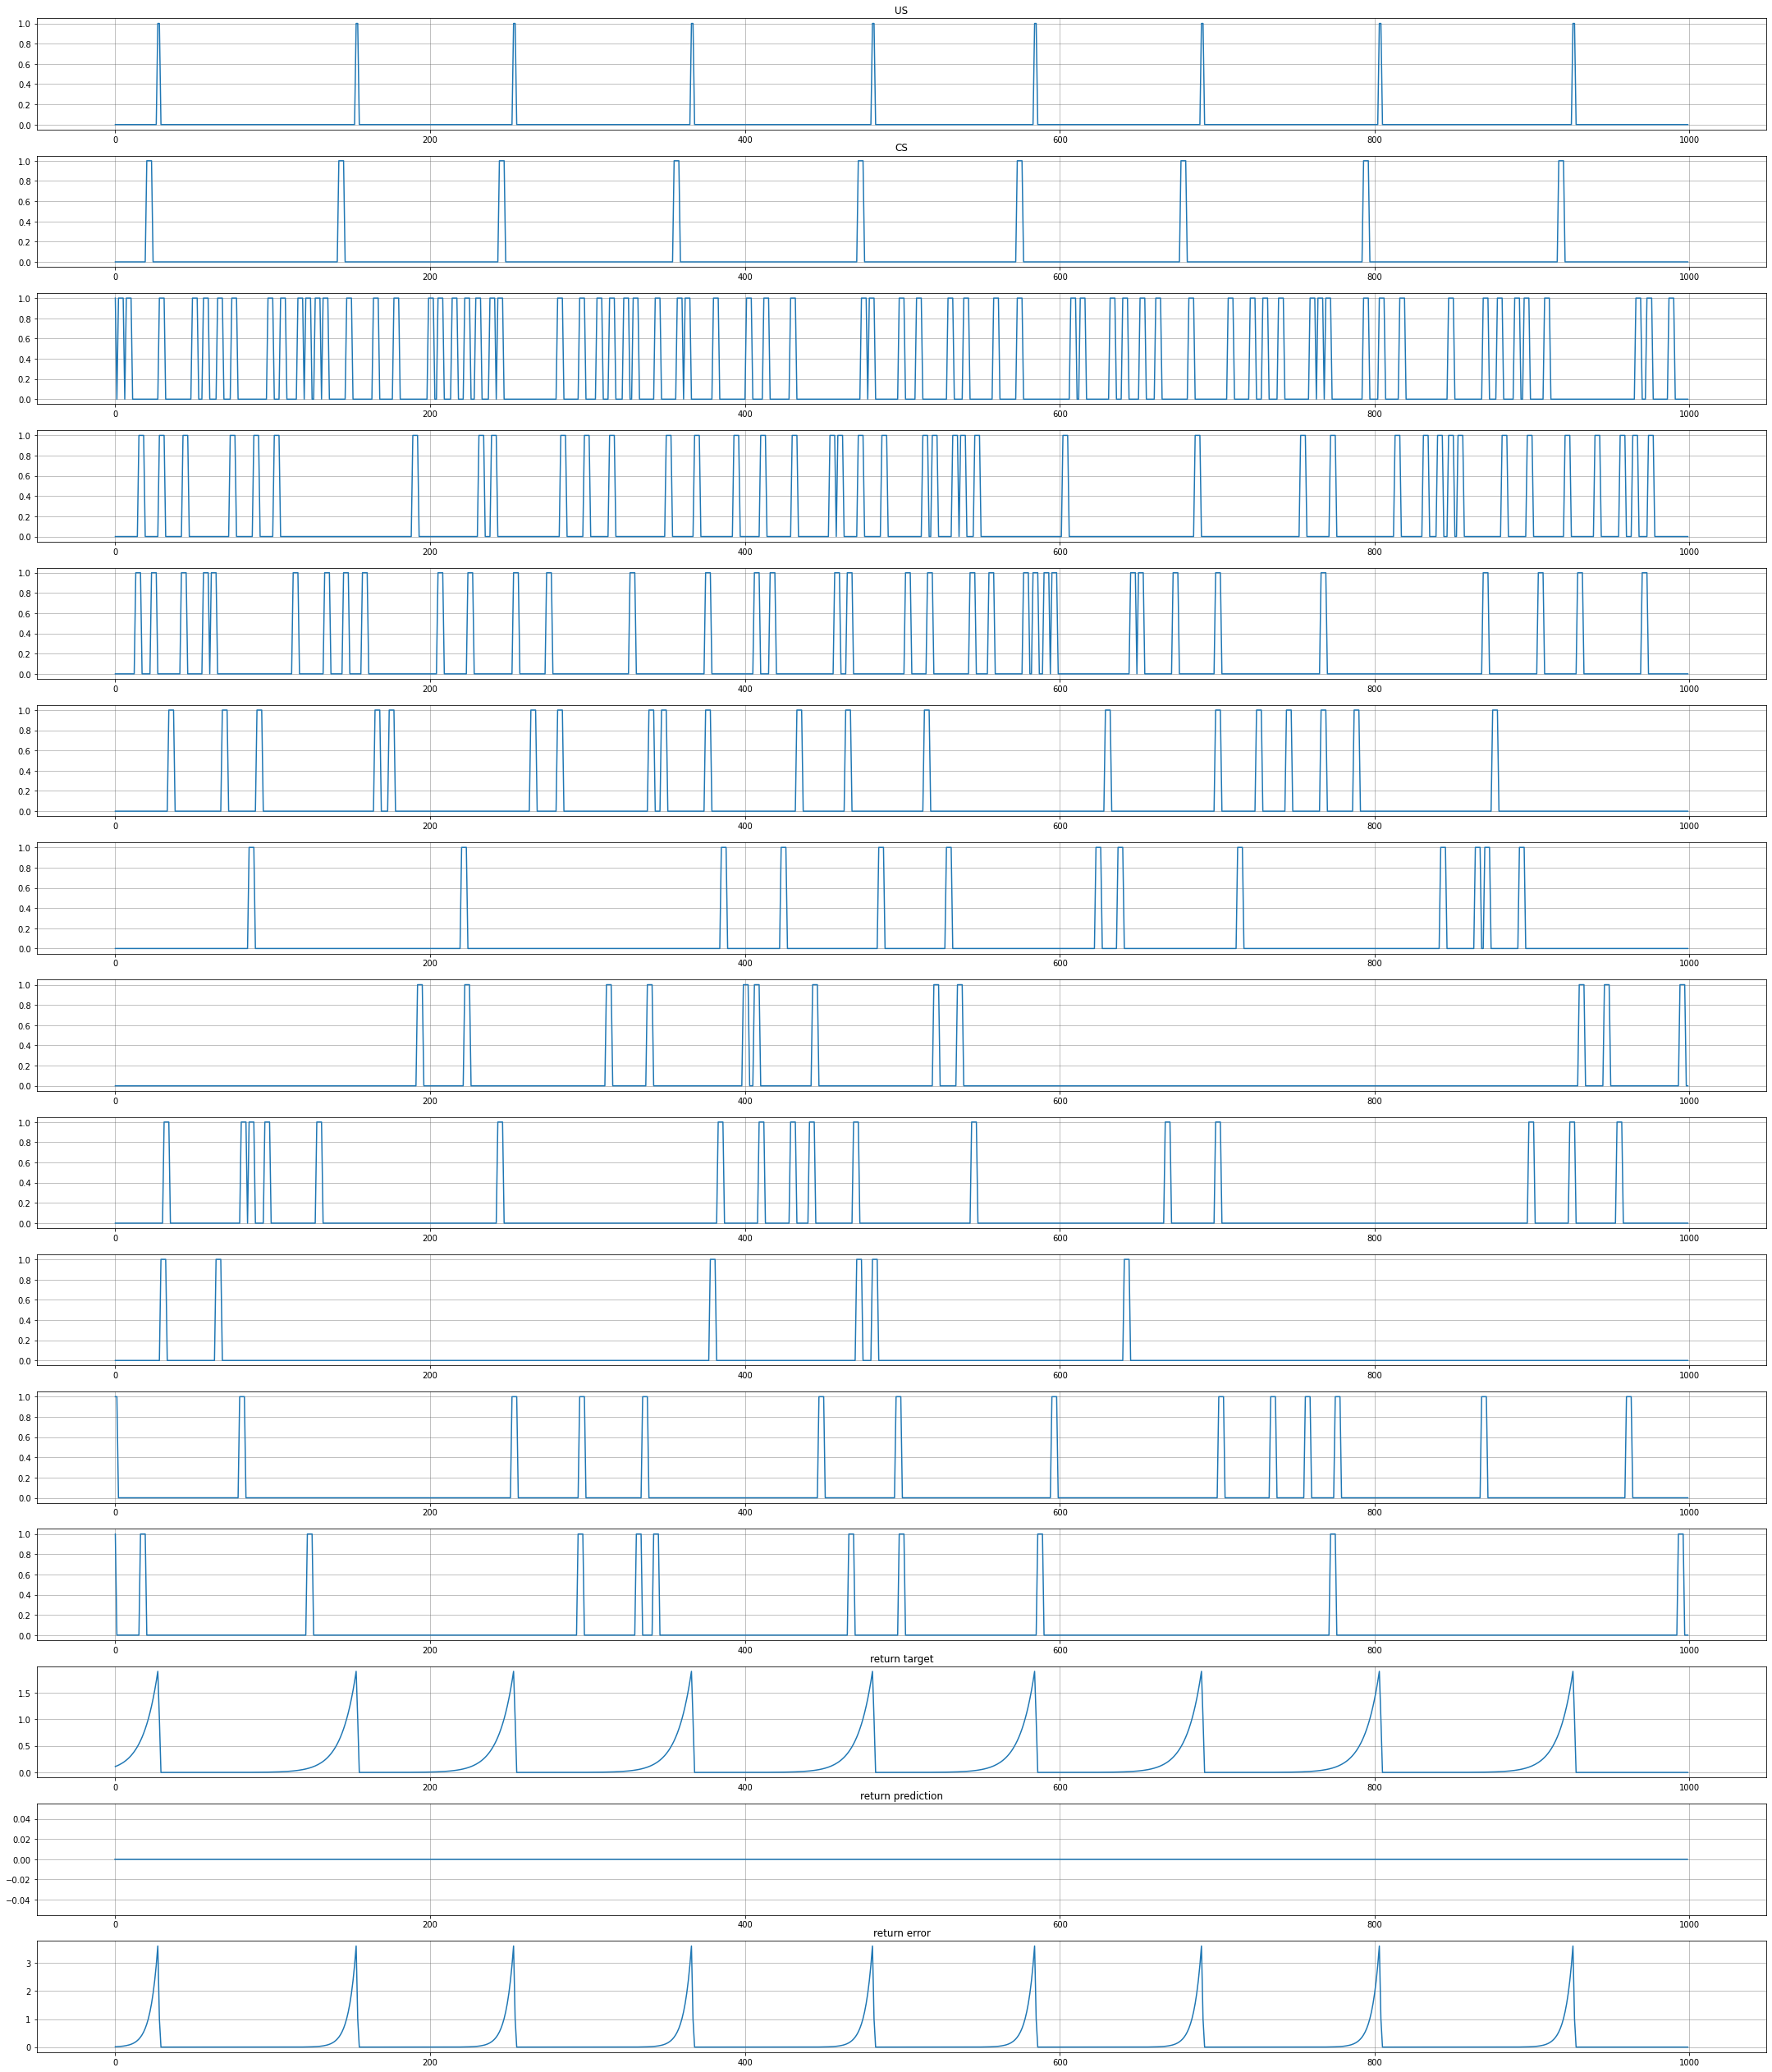

In [340]:
nsteps = cfg['N_TRAIN_STEPS']
to_plot = 1000
nobs = cfg['NUM_CS'] + cfg['NUM_US'] + cfg['NUM_DIST']
obsall = np.zeros([nsteps,cfg['NUM_CS'] + cfg['NUM_US'] + cfg['NUM_DIST']])
rwdall = np.zeros(nsteps)

for i in range(nsteps):
    obs = tc.step(_)
    obsall[i] = obs.observation
    rwdall[i] = obs.reward

fig, axs = plt.subplots(nobs+3,figsize=(30, 35))
fig.tight_layout()
for i in range(nobs):
    axs[i].plot(list(range(to_plot)), obsall[:, i][-to_plot:])
    
p = np.zeros(cfg['N_TRAIN_STEPS'])
errors = compute_return_error(rwdall, p, cfg['GAMMA'])

axs[-3].plot(list(range(to_plot)), errors[2][-to_plot:] )
axs[-2].plot(list(range(to_plot)), p[-to_plot:] )
axs[-1].plot(list(range(to_plot)), errors[1][-to_plot:])

axs[0].title.set_text('US')
axs[1].title.set_text('CS')
axs[-3].title.set_text('return target')
axs[-2].title.set_text('return prediction')
axs[-1].title.set_text('return error')
for ax in axs:
    ax.grid(color='#666666', linestyle='-', alpha=0.5)

print(f'MSE: {errors[0]}')

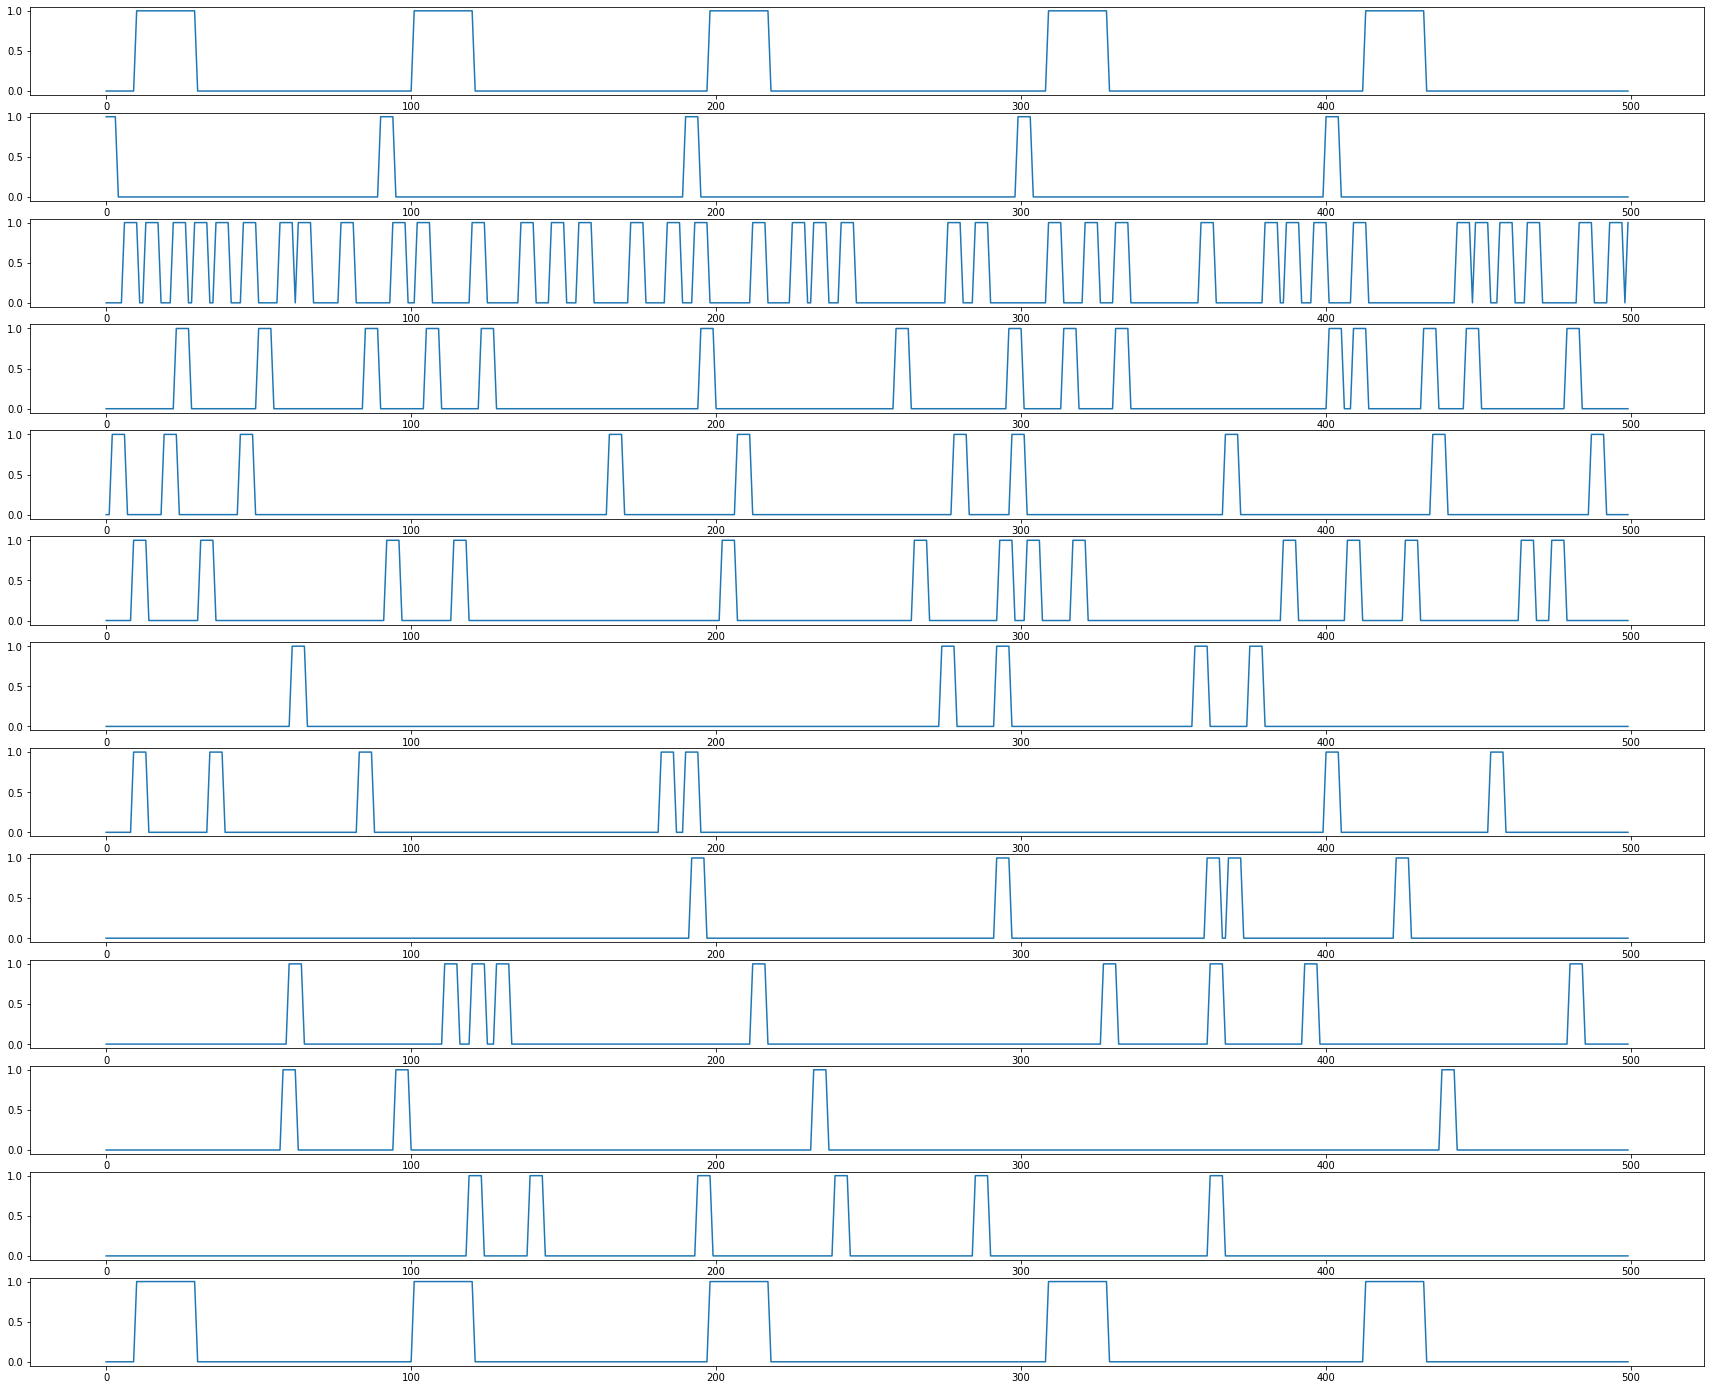

In [93]:
nsteps = 500
nobs = 12
obsall = np.ones([nsteps,12])
rwd = np.ones(nsteps)
for i in range(nsteps):
    obs = tc.step(_)
    obsall[i] = obs.observation
    rwd[i] = obs.reward

fig, axs = plt.subplots(nobs+1,figsize=(30, 25))
for i in range(nobs):
    axs[i].plot(list(range(nsteps)), obsall[:, i])
axs[-1].plot(list(range(nsteps)), rwd)

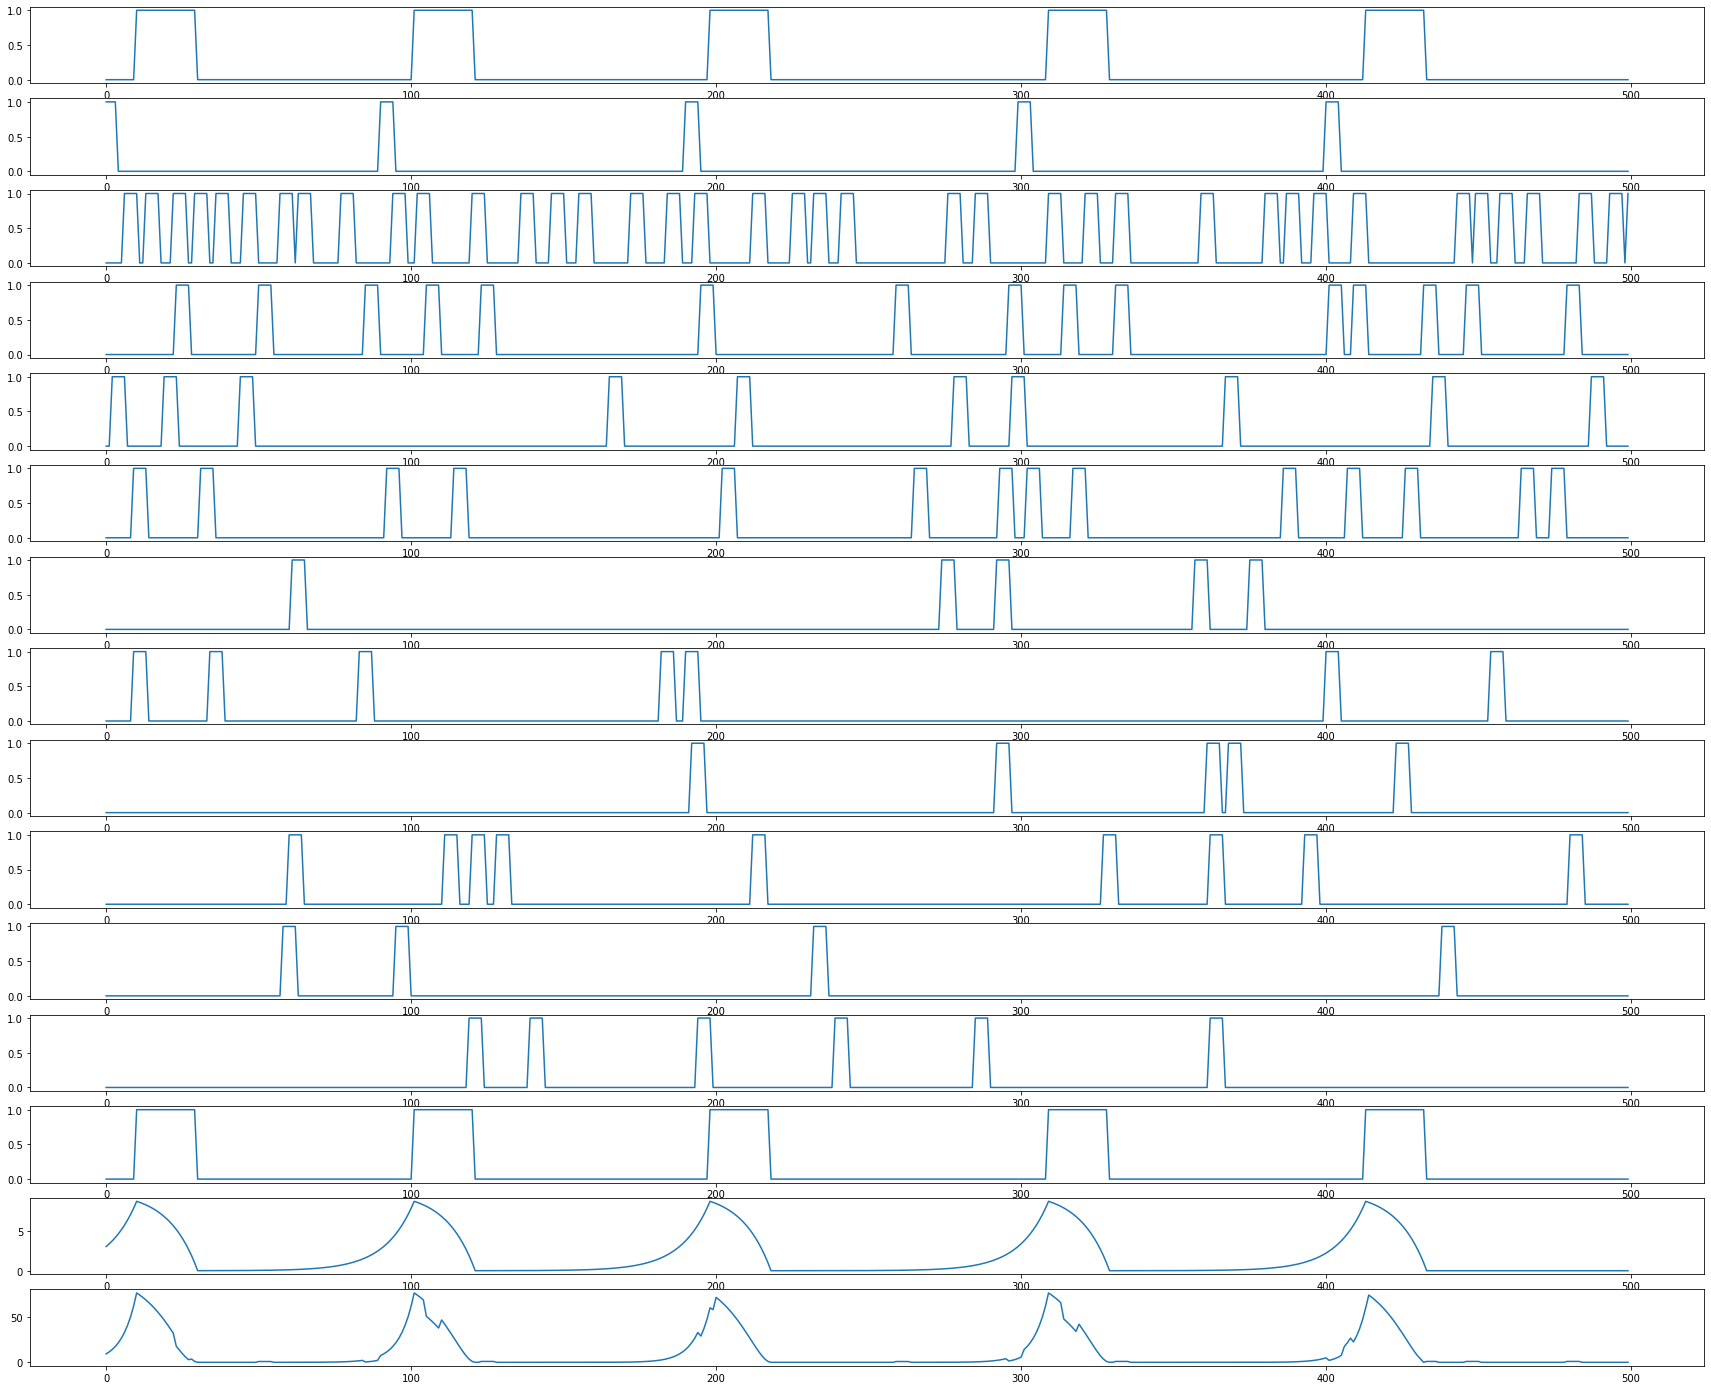

In [120]:
a = compute_return_error(rwd,obsall[:,3],0.9)
fig, axs = plt.subplots(nobs+3,figsize=(30, 25))
for i in range(nobs):
    axs[i].plot(list(range(nsteps)), obsall[:, i])
axs[-3].plot(list(range(nsteps)), rwd)
axs[-2].plot(list(range(nsteps)), a[2], )
axs[-1].plot(list(range(nsteps)), a[1], )